Toda empresa que tem presença na internet pode estar interessada em extrair insights 
de comentários de usuários sobre seus produtos ou serviços, sobre concorrentes, sobre o 
mercado ou sobre suas próprias preferências.

Neste projeto teremos em mãos dados de texto simulando comentários de usuários. 
Dados de texto são dados em formato não estruturado e seria muito difícil usar um Data 
Warehouse para armazenar os dados e realizar análise. Por essa razão, usaremos um Data Lake, 
onde os dados serão carregados em seu formato bruto e então faremos o pré-processamento 
dos dados em tempo de análise para entregar insights aos tomadores de decisão

Para este projeto foi usado uma massa de dados fictícios simulando posts de 
comentários de usuários em redes sociais e/ou blogs. Usaremos o site abaixo para gerar a massa 
de dados:


https://www.mockaroo.com/

## Conectando no Data Lake


In [2]:
import json
import pymongo 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
client = pymongo.MongoClient('mongodb://localhost:27017')

In [4]:
client

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)

In [5]:
datalake = client.datalake

In [6]:
posts = datalake['posts']

In [9]:
# Carrega o arquivo json simulando posts de redes sociais (ficticios)
with open('dataset.json') as file:
    file_data = json.load(file)

In [10]:
file_data

[{'status': 'public',
  'creationDate': '2017-07-17T20:05:49Z',
  'allowComments': True,
  'title': 'ligula nec sem duis aliquam',
  'description': 'in felis eu sapien cursus vestibulum proin eu mi nulla ac enim in tempor turpis nec euismod scelerisque quam turpis adipiscing lorem vitae mattis nibh ligula nec sem duis aliquam convallis nunc proin at turpis a pede posuere nonummy integer non velit donec diam neque vestibulum eget vulputate ut ultrices vel augue vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae donec pharetra magna vestibulum aliquet ultrices erat tortor sollicitudin mi sit amet lobortis sapien sapien non mi integer ac neque duis bibendum morbi non',
  'tags': 1,
  'Category': 'lifestyle',
  'filteredPicture': False},
 {'status': 'private',
  'creationDate': '2019-01-19T15:45:57Z',
  'allowComments': False,
  'title': 'mus vivamus vestibulum sagittis sapien cum',
  'description': 'nec nisi volutpat eleifend donec ut dolor morbi vel le

## Carregando Dados no Data Lake

In [11]:
# Insere o conteúdo do arquivo json na coleção chamada posts. Cada item do arquivo será um documento.
posts.insert_many(file_data, ordered = False, bypass_document_validation = True)

In [12]:
# Retorna 1 item
posts.find_one()
# dics:
# _id (primary key)
# status
# creationDate 
# allowComments
# title
# description
# tags
# Category
# filteredPicture

{'_id': ObjectId('658c746b3d2bfc3370167ce0'),
 'status': 'public',
 'creationDate': '2017-07-17T20:05:49Z',
 'allowComments': True,
 'title': 'ligula nec sem duis aliquam',
 'description': 'in felis eu sapien cursus vestibulum proin eu mi nulla ac enim in tempor turpis nec euismod scelerisque quam turpis adipiscing lorem vitae mattis nibh ligula nec sem duis aliquam convallis nunc proin at turpis a pede posuere nonummy integer non velit donec diam neque vestibulum eget vulputate ut ultrices vel augue vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae donec pharetra magna vestibulum aliquet ultrices erat tortor sollicitudin mi sit amet lobortis sapien sapien non mi integer ac neque duis bibendum morbi non',
 'tags': 1,
 'Category': 'lifestyle',
 'filteredPicture': False}

In [13]:
# Extraindo o numero de documentos em 'posts'
n = posts.estimated_document_count()

In [14]:
n

2000

## Pré-Processamento e Análise

> Agregação para calcular o número de posts em cada categoria.

In [15]:
# Retorna 1 item
posts.find_one()
# dics:
# _id (primary key)
# status
# creationDate 
# allowComments
# title
# description
# tags
# Category
# filteredPicture

{'_id': ObjectId('658c746b3d2bfc3370167ce0'),
 'status': 'public',
 'creationDate': '2017-07-17T20:05:49Z',
 'allowComments': True,
 'title': 'ligula nec sem duis aliquam',
 'description': 'in felis eu sapien cursus vestibulum proin eu mi nulla ac enim in tempor turpis nec euismod scelerisque quam turpis adipiscing lorem vitae mattis nibh ligula nec sem duis aliquam convallis nunc proin at turpis a pede posuere nonummy integer non velit donec diam neque vestibulum eget vulputate ut ultrices vel augue vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae donec pharetra magna vestibulum aliquet ultrices erat tortor sollicitudin mi sit amet lobortis sapien sapien non mi integer ac neque duis bibendum morbi non',
 'tags': 1,
 'Category': 'lifestyle',
 'filteredPicture': False}

In [16]:
# Agregação para calcular o número de posts em cada categoria

# $group -> operador de agrupamento, associando categoria ao id. por fim faça uma contagem do count
# ordenando por categoria, do menor para o maior
posts_cat = posts.aggregate([{"$group": {"_id": "$Category", "count": {"$sum": 1}}},
                             {"$sort": {"_id.Category": 1, "count": -1}}])

In [17]:
print(posts_cat)

In [18]:
pc_df = pd.DataFrame(list(posts_cat))

In [21]:
pc_df.head(10)

,_id,count
0,arts,311
1,fashion,300
2,lifestyle,294
3,movies,289
4,politics,274
5,educational,274
6,sports,258


In [20]:
list(pc_df['_id'])

['arts', 'fashion', 'lifestyle', 'movies', 'politics', 'educational', 'sports']

<Axes: ylabel='count'>

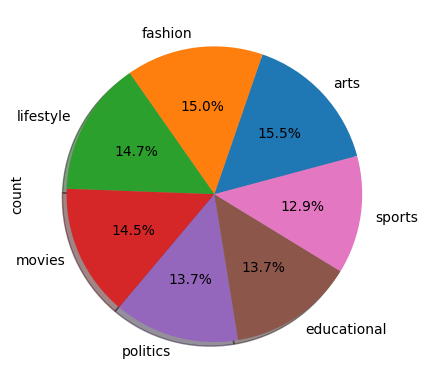

In [23]:
pc_df.plot.pie(y = 'count',
               labels = pc_df['_id'],
               autopct = '%1.1f%%',
               startangle = 15, 
               shadow = True,
               legend = False)

> Número de posts públicos e privados da categoria **politics**.

In [24]:
# Número de posts públicos e privados da categoria politics

# match -> operador de filtro, filtrando a 'Category' por 'politics'
# agrupando e fznd uma contagem por status (public or private),
pol_sta = posts.aggregate([{"$match": {"Category": "politics"}},
                           {"$group": {"_id": "$status", "count": {"$sum": 1}}}])

In [25]:
ps_df = pd.DataFrame(list(pol_sta))

In [26]:
ps_df

,_id,count
0,private,148
1,public,126


<Axes: title={'center': 'Número de Posts Públicos e Privados'}, xlabel='_id'>

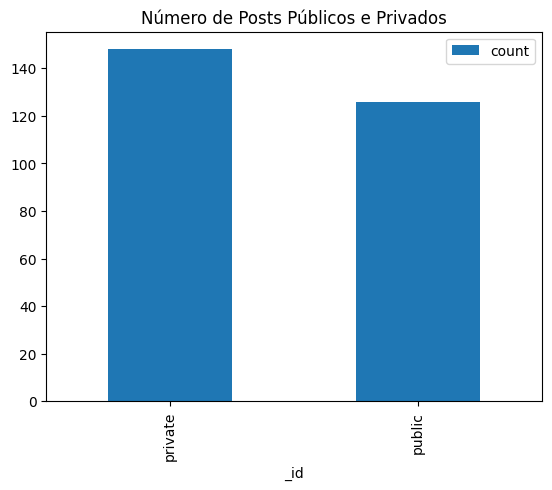

In [27]:
ps_df.plot.bar(x = '_id',
               y = 'count',
               title = "Número de Posts Públicos e Privados")

> Qual ano teve o maior número de posts?

In [28]:
# Retorna 1 item
posts.find_one()
# dics:
# _id (primary key)
# status
# creationDate 
# allowComments
# title
# description
# tags
# Category
# filteredPicture

{'_id': ObjectId('658c746b3d2bfc3370167ce0'),
 'status': 'public',
 'creationDate': '2017-07-17T20:05:49Z',
 'allowComments': True,
 'title': 'ligula nec sem duis aliquam',
 'description': 'in felis eu sapien cursus vestibulum proin eu mi nulla ac enim in tempor turpis nec euismod scelerisque quam turpis adipiscing lorem vitae mattis nibh ligula nec sem duis aliquam convallis nunc proin at turpis a pede posuere nonummy integer non velit donec diam neque vestibulum eget vulputate ut ultrices vel augue vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae donec pharetra magna vestibulum aliquet ultrices erat tortor sollicitudin mi sit amet lobortis sapien sapien non mi integer ac neque duis bibendum morbi non',
 'tags': 1,
 'Category': 'lifestyle',
 'filteredPicture': False}

In [29]:
# Update many (cria duas noovas variáveis para cada documento)
datalake.posts.update_many({}, {'$set': {"hour": 0}});
datalake.posts.update_many({}, {'$set': {"year": 0}});

In [30]:
# Retorna 1 item
posts.find_one()
# dics:
# _id (primary key)
# status
# creationDate 
# allowComments
# title
# description
# tags
# Category
# filteredPicture
# hour
# year


{'_id': ObjectId('658c746b3d2bfc3370167ce0'),
 'status': 'public',
 'creationDate': '2017-07-17T20:05:49Z',
 'allowComments': True,
 'title': 'ligula nec sem duis aliquam',
 'description': 'in felis eu sapien cursus vestibulum proin eu mi nulla ac enim in tempor turpis nec euismod scelerisque quam turpis adipiscing lorem vitae mattis nibh ligula nec sem duis aliquam convallis nunc proin at turpis a pede posuere nonummy integer non velit donec diam neque vestibulum eget vulputate ut ultrices vel augue vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae donec pharetra magna vestibulum aliquet ultrices erat tortor sollicitudin mi sit amet lobortis sapien sapien non mi integer ac neque duis bibendum morbi non',
 'tags': 1,
 'Category': 'lifestyle',
 'filteredPicture': False,
 'hour': 0,
 'year': 0}

In [31]:
# Update one (atualiza as duas variáveis com os valores correspondentes extraídos da coluna de data)
for data in posts.find({}):
    # para cada documento encontrando, vou fazer uma atualização:
    posts.update_one({"_id": data['_id']},
                     # Separando por hora e data da postagem, identificada pela cahve 'creationDate'
                     {'$set': {'hour' : data['creationDate'].split('T')[1].split(':')[0],
                               'year' : data['creationDate'].split('T')[0].split('-')[0] }})

In [32]:
# Retorna 1 item
posts.find_one()
# dics:
# _id (primary key)
# status
# creationDate 
# allowComments
# title
# description
# tags
# Category
# filteredPicture
# hour
# year


{'_id': ObjectId('658c746b3d2bfc3370167ce0'),
 'status': 'public',
 'creationDate': '2017-07-17T20:05:49Z',
 'allowComments': True,
 'title': 'ligula nec sem duis aliquam',
 'description': 'in felis eu sapien cursus vestibulum proin eu mi nulla ac enim in tempor turpis nec euismod scelerisque quam turpis adipiscing lorem vitae mattis nibh ligula nec sem duis aliquam convallis nunc proin at turpis a pede posuere nonummy integer non velit donec diam neque vestibulum eget vulputate ut ultrices vel augue vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae donec pharetra magna vestibulum aliquet ultrices erat tortor sollicitudin mi sit amet lobortis sapien sapien non mi integer ac neque duis bibendum morbi non',
 'tags': 1,
 'Category': 'lifestyle',
 'filteredPicture': False,
 'hour': '20',
 'year': '2017'}

In [33]:
posts_yr = posts.aggregate([{"$group": {"_id": "$year", "count": {"$sum": 1}}},
                            {"$sort": {"_id.year": 1, "count": 1}}])

In [34]:
py_df = pd.DataFrame(list(posts_yr))
py_df

,_id,count
0,2015,76
1,2016,299
2,2019,303
3,2017,309
4,2021,330
5,2020,334
6,2018,349


<Axes: title={'center': 'Número de Posts Por Ano'}, xlabel='_id'>

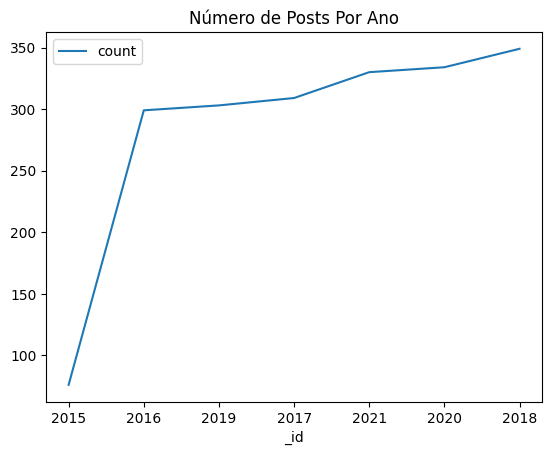

In [35]:
py_df.plot.line(x = '_id',
                y = 'count',
                title = "Número de Posts Por Ano")

> Qual o horário com maior número de posts?

In [67]:
posts_hr = posts.aggregate([{"$group": {"_id": "$hour", "count": {"$sum": 1}}},
                            {"$sort": {"_id.hour": 1, "count": -1}}])

In [68]:
posts_list = list(posts_hr)
print(posts_list)


[{'_id': '00', 'count': 103}, {'_id': '08', 'count': 101}, {'_id': '02', 'count': 99}, {'_id': '19', 'count': 97}, {'_id': '11', 'count': 93}, {'_id': '14', 'count': 90}, {'_id': '10', 'count': 88}, {'_id': '16', 'count': 88}, {'_id': '17', 'count': 87}, {'_id': '01', 'count': 86}, {'_id': '20', 'count': 85}, {'_id': '18', 'count': 85}, {'_id': '13', 'count': 82}, {'_id': '04', 'count': 82}, {'_id': '07', 'count': 82}, {'_id': '21', 'count': 81}, {'_id': '09', 'count': 80}, {'_id': '05', 'count': 79}, {'_id': '23', 'count': 76}, {'_id': '06', 'count': 75}, {'_id': '22', 'count': 70}, {'_id': '03', 'count': 65}, {'_id': '15', 'count': 64}, {'_id': '12', 'count': 62}]


In [69]:
posts_hr = posts.aggregate([{"$group": {"_id": "$hour", "count": {"$sum": 1}}},
                            {"$sort": {"_id.hour": 1, "count": -1}}])

In [70]:
# Somente as 3 primeiras
for i in range(24):
    print(posts_hr.next())

{'_id': '00', 'count': 103}
{'_id': '08', 'count': 101}
{'_id': '02', 'count': 99}
{'_id': '19', 'count': 97}
{'_id': '11', 'count': 93}
{'_id': '14', 'count': 90}
{'_id': '16', 'count': 88}
{'_id': '10', 'count': 88}
{'_id': '17', 'count': 87}
{'_id': '01', 'count': 86}
{'_id': '20', 'count': 85}
{'_id': '18', 'count': 85}
{'_id': '04', 'count': 82}
{'_id': '13', 'count': 82}
{'_id': '07', 'count': 82}
{'_id': '21', 'count': 81}
{'_id': '09', 'count': 80}
{'_id': '05', 'count': 79}
{'_id': '23', 'count': 76}
{'_id': '06', 'count': 75}
{'_id': '22', 'count': 70}
{'_id': '03', 'count': 65}
{'_id': '15', 'count': 64}
{'_id': '12', 'count': 62}


> Número de posts em hora cheia (terminada por 00) por categoria.

In [71]:
# filtrando, agregando e ordenando
cat_00 = posts.aggregate([{"$match": {"hour": "00"}},
                          {"$group": {"_id": "$Category", "count": {"$sum": 1}}},
                          {"$sort": {"_id.Category": 1, "count": -1}}])

In [72]:
c0_df = pd.DataFrame(list(cat_00))

<Axes: title={'center': 'Número de Posts em Hora Cheia'}, xlabel='_id'>

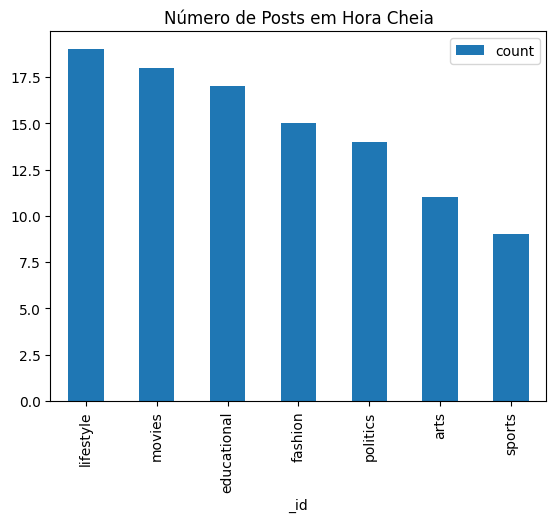

In [73]:
c0_df.plot.bar(x = '_id', y = 'count', title = "Número de Posts em Hora Cheia")

> Número de posts que permitem comentários.

In [74]:
com = posts.count_documents({'allowComments':True})

In [75]:
print("Número de Posts Que Permitem Comentários:", com)

Número de Posts Que Permitem Comentários: 964


In [76]:
print("Número de Posts Que Não Permitem Comentários:", n-com)

Número de Posts Que Não Permitem Comentários: 1036


Text(0, 0.5, 'Número de Posts')

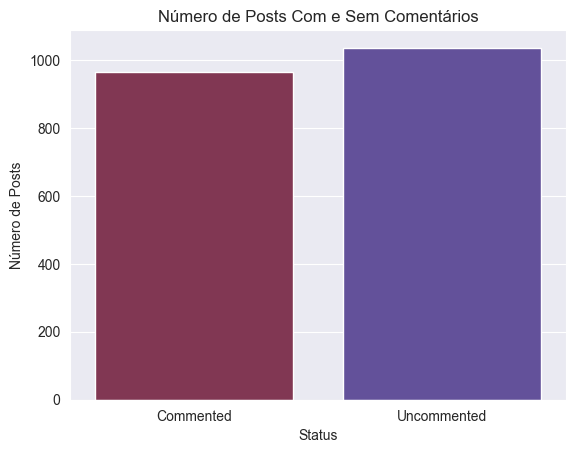

In [78]:
sns.set_style('darkgrid')
x = ['Commented', 'Uncommented']
y = [com, n-com]
sns.barplot(x=x, y=y, palette = 'twilight_r')
plt.title("Número de Posts Com e Sem Comentários")
plt.xlabel("Status")
plt.ylabel("Número de Posts")

> Comprimento (número de palavras) do título dos posts.

In [79]:
# Retorna 1 item
posts.find_one()
# dics:
# _id (primary key)
# status
# creationDate 
# allowComments
# title
# description
# tags
# Category
# filteredPicture
# hour
# year


{'_id': ObjectId('658c746b3d2bfc3370167ce0'),
 'status': 'public',
 'creationDate': '2017-07-17T20:05:49Z',
 'allowComments': True,
 'title': 'ligula nec sem duis aliquam',
 'description': 'in felis eu sapien cursus vestibulum proin eu mi nulla ac enim in tempor turpis nec euismod scelerisque quam turpis adipiscing lorem vitae mattis nibh ligula nec sem duis aliquam convallis nunc proin at turpis a pede posuere nonummy integer non velit donec diam neque vestibulum eget vulputate ut ultrices vel augue vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae donec pharetra magna vestibulum aliquet ultrices erat tortor sollicitudin mi sit amet lobortis sapien sapien non mi integer ac neque duis bibendum morbi non',
 'tags': 1,
 'Category': 'lifestyle',
 'filteredPicture': False,
 'hour': '20',
 'year': '2017'}

In [80]:
# Criando uma nova coluna para fazer a contagem do numero de palavras contida no titulo dos posts
datalake.posts.update_many({}, {'$set': {"length_of_heading": 0}});

In [81]:
# Preechendo a nova coluna
for data in posts.find({}):
    # Para todos os posts encontrando em posts.find({})
    posts.update_one({"_id": data['_id']},
                     # defina para a coluna 'length_of_heading', o tamanho do titulo splitando a cada espaço (count numero de palavras)
                     {'$set': {'length_of_heading' : len(data['title'].split(' '))}})

In [82]:
len_titles = posts.aggregate([{"$group": {"_id": "$length_of_heading", "count": {"$sum": 1}}},
                              {"$sort": {"_id.length_of_heading": 1, "count": -1}}])

In [83]:
len_titles

In [84]:
title_df = pd.DataFrame(list(len_titles))
title_df.head(10)

,_id,count
0,3,355
1,4,345
2,1,343
3,5,337
4,6,336
5,2,284


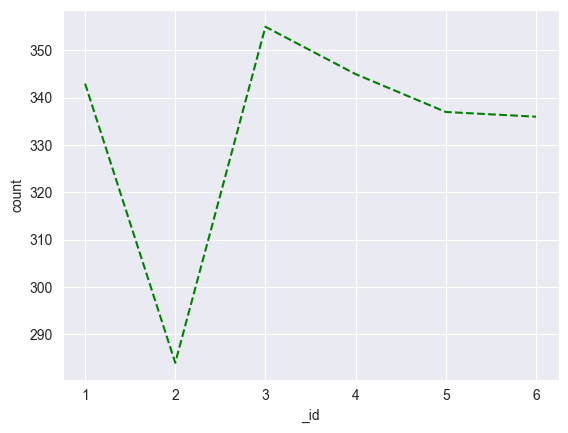

In [85]:
ax = sns.lineplot(x = '_id', y = 'count', data = title_df, color = 'green')
ax.lines[0].set_linestyle("--")
plt.show()

> Número de tags por categoria de posts.

In [88]:
# Agregando por tags, fznd a count(pela soma), e ordenando em ordem decrescente
tags = posts.aggregate([{"$group": {"_id": "$tags", "count": {"$sum": 1}}},
                        {"$sort": {"_id.tags": 1, "count": -1}}])

In [89]:
cat_tags = posts.find({'tags': {'$gt':0}}, {'Category':1})
cat_tags

In [90]:
# Categorias com posts com maior número de tags, sendo o número de tags maior do que zero
cat_tags = posts.aggregate([{"$match": {"tags": {"$gt":0}}},
                            {"$group": {"_id": "$Category", "count": {"$sum": 1}}},
                            {"$sort": {"_id.tags": 1, "count": -1}}])

In [91]:
ct_df = pd.DataFrame(list(cat_tags))
ct_df

,_id,count
0,fashion,276
1,arts,276
2,movies,264
3,lifestyle,262
4,politics,258
5,educational,255
6,sports,235


<Axes: xlabel='_id', ylabel='count'>

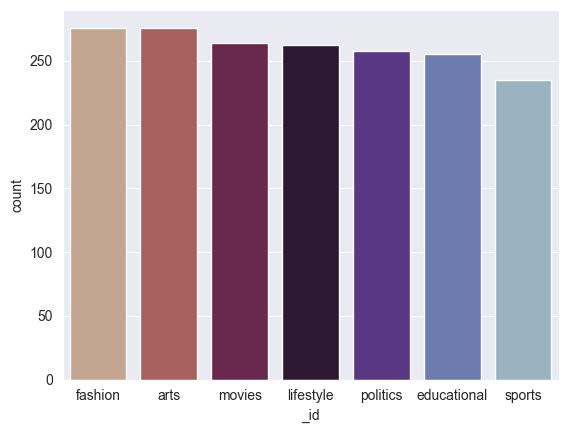

In [92]:
sns.barplot(x = '_id', y = 'count', data = ct_df, palette = 'twilight_r')

> Qual categoria usa mais filtros de fotos/imagens?

In [93]:
cat_fs = posts.aggregate([{"$match": {"filteredPicture": True}},
                          {"$group":{"_id": "$Category", "count": {"$sum": 1}}},
                          {"$sort": {"_id.tags": 1, "count": -1}}])

In [94]:
for i in range(7):
    print(cat_fs.next())

{'_id': 'fashion', 'count': 159}
{'_id': 'movies', 'count': 154}
{'_id': 'arts', 'count': 146}
{'_id': 'lifestyle', 'count': 136}
{'_id': 'educational', 'count': 135}
{'_id': 'politics', 'count': 131}
{'_id': 'sports', 'count': 117}


> Nível Ninja: Qual categoria tem posts (descrição) mais longos (com maior número de palavras), acima de 60 caracteres?

In [95]:
# Criando a variavel tamanho dos posts (descrição)
datalake.posts.update_many({}, {'$set': {"length_of_des": 0}});

In [96]:
# preenchendo a variavel criada:
for data in posts.find({}):
    posts.update_one({"_id": data['_id']}, {'$set': {'length_of_des': len(data['description'].split(' '))}})

In [97]:
# Filtro, agregação e ordenação
cat_des = posts.aggregate([{"$match": {"length_of_des": {"$gte":60}}},
                           {"$group":{"_id": "$Category", "count": {"$sum": 1}}},
                           {"$sort": {"_id.tags": 1, "count": -1}}])

In [98]:
for i in range(7):
    print(cat_des.next())

{'_id': 'arts', 'count': 178}
{'_id': 'fashion', 'count': 161}
{'_id': 'movies', 'count': 159}
{'_id': 'educational', 'count': 156}
{'_id': 'lifestyle', 'count': 156}
{'_id': 'politics', 'count': 146}
{'_id': 'sports', 'count': 130}


In [99]:
# Retorna 1 item
posts.find_one()
# dics:
# _id (primary key)
# status
# creationDate 
# allowComments
# title
# description
# tags
# Category
# filteredPicture
# hour
# year


{'_id': ObjectId('658c746b3d2bfc3370167ce0'),
 'status': 'public',
 'creationDate': '2017-07-17T20:05:49Z',
 'allowComments': True,
 'title': 'ligula nec sem duis aliquam',
 'description': 'in felis eu sapien cursus vestibulum proin eu mi nulla ac enim in tempor turpis nec euismod scelerisque quam turpis adipiscing lorem vitae mattis nibh ligula nec sem duis aliquam convallis nunc proin at turpis a pede posuere nonummy integer non velit donec diam neque vestibulum eget vulputate ut ultrices vel augue vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae donec pharetra magna vestibulum aliquet ultrices erat tortor sollicitudin mi sit amet lobortis sapien sapien non mi integer ac neque duis bibendum morbi non',
 'tags': 1,
 'Category': 'lifestyle',
 'filteredPicture': False,
 'hour': '20',
 'year': '2017',
 'length_of_heading': 5,
 'length_of_des': 89}

> Nível Ninja das Galáxias: O número de posts (descrição) varia de acordo com a hora do dia? Aumenta ou diminui?

In [100]:
# Agregação e ordenação por hora e categoria
posts_hr = posts.aggregate([{"$group": {"_id": ["$hour", "$Category"], "count": {"$sum": 1}}},
                            {"$sort": {"_id.hour": 1, "count": -1}}])

In [101]:
postshr_df = pd.DataFrame(posts_hr)
postshr_df

,_id,count
0,"[11, arts]",23
1,"[08, politics]",21
2,"[16, lifestyle]",20
3,"[11, educational]",20
4,"[10, fashion]",19
...,...,...
163,"[13, sports]",5
164,"[22, politics]",5
165,"[06, sports]",5
166,"[11, lifestyle]",4


In [102]:
split_df = pd.DataFrame(postshr_df ['_id'].to_list(), columns = ['hour', 'category'])
split_df

,hour,category
0,11,arts
1,08,politics
2,16,lifestyle
3,11,educational
4,10,fashion
...,...,...
163,13,sports
164,22,politics
165,06,sports
166,11,lifestyle


In [104]:
df = pd.concat([split_df, postshr_df['count']], axis = 1)
df

,hour,category,count
0,11,arts,23
1,08,politics,21
2,16,lifestyle,20
3,11,educational,20
4,10,fashion,19
...,...,...,...
163,13,sports,5
164,22,politics,5
165,06,sports,5
166,11,lifestyle,4


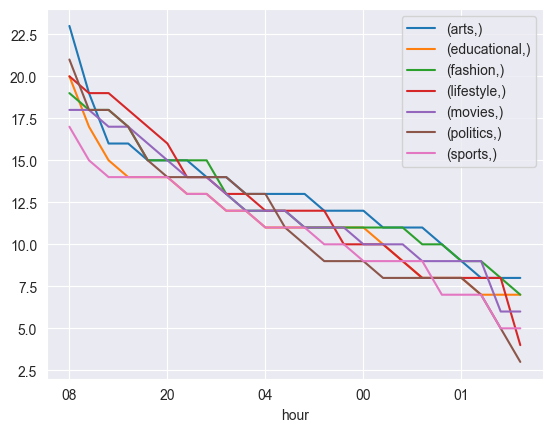

In [105]:
fig, ax = plt.subplots()
for key, grp in df.groupby(['category']):
    ax = grp.plot(ax = ax, kind = 'line', x = 'hour', y = 'count', label = key)

plt.legend(loc = 'best')
plt.show()

## Relatório: